In [56]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

# 데이터 불러오기

In [57]:
# 데이터 로딩
train_X_data = pd.read_csv('./train_set/train_X_data_RS.csv', index_col='datetime', parse_dates=True)
test_X_data = pd.read_csv('./test_set/test_X_data_RS.csv', index_col='datetime', parse_dates=True)
train_Y_data = pd.read_csv('./train_set/train_Y_data.csv', index_col='datetime', parse_dates=True)
test_Y_data = pd.read_csv('./test_set/test_Y_data.csv', index_col='datetime', parse_dates=True)


# X 데이터의 모든 열을 숫자형으로 변환
# apply(pd.to_numeric, errors='coerce')를 사용하면 변환되지 않는 값이 NaN으로 변환
train_X_data = train_X_data.apply(pd.to_numeric, errors='coerce') 
test_X_data = test_X_data.apply(pd.to_numeric, errors='coerce')

# 타겟 변수의 'Kp' 열을 숫자형으로 변환
train_Y_data['Kp'] = pd.to_numeric(train_Y_data['Kp'], errors='coerce')
test_Y_data['Kp'] = pd.to_numeric(test_Y_data['Kp'], errors='coerce')

# print(train_X_data.head)
# print(train_Y_data.head)

# 정규화

In [58]:
# 데이터 스케일링
scaler_X = MinMaxScaler()
scaler_Y = MinMaxScaler()

# 훈련 데이터에 대해 스케일러 학습 및 변환
train_X_data = scaler_X.fit_transform(train_X_data)
# train_Y_data = scaler_Y.fit_transform(train_Y_data)

# 테스트 데이터에 대해 스케일러 변환
test_X_data = scaler_X.transform(test_X_data)
# test_Y_data = scaler_Y.transform(test_Y_data)

# ARIMAX

### ADF test

In [59]:
# Augmented Dickey–Fuller test:
print('Results of Dickey Fuller Test:')
# adfuller 함수로 ADF 테스트
adf_test = adfuller(train_Y_data)
"""
	•	dftest[0]: 테스트 통계량(Test Statistic).
	•	dftest[1]: p-value.
	•	dftest[2]: 사용된 지연 수(Lags Used).
	•	dftest[3]: 사용된 관측치 수(Number of Observations Used).
	•	dftest[4]: 각 임계값에 대한 테스트 통계량의 Critical Values.
"""
adf_result = pd.Series(adf_test[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key, value in adf_test[4].items():
    adf_result[f'Critical Value ({key})'] = value

print(adf_result)

Results of Dickey Fuller Test:
Test Statistic                -1.386826e+01
p-value                        6.536600e-26
#Lags Used                     5.400000e+01
Number of Observations Used    4.085600e+04
Critical Value (1%)           -3.430510e+00
Critical Value (5%)           -2.861611e+00
Critical Value (10%)          -2.566808e+00
dtype: float64


### ACF & PACF

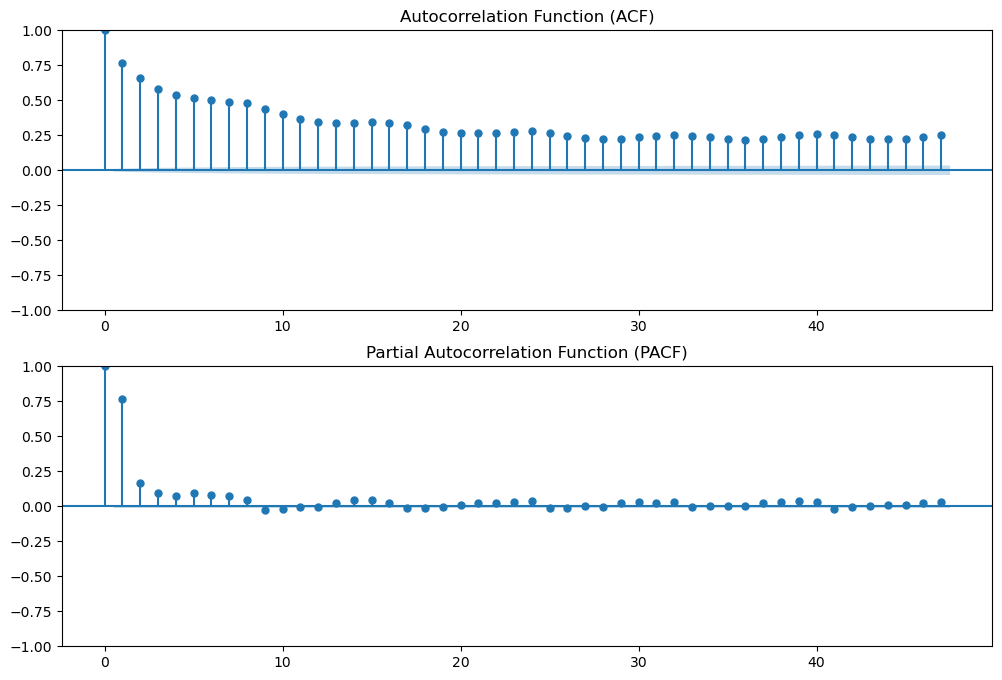

In [60]:
# 시계열 데이터의 자기상관성을 시각적으로 확인
# Plot ACF and PACF for the training data

# 그래프 공간 생성
fig, ax = plt.subplots(2, 1, figsize=(12, 8))

# train_diff 의 자기상관 함수(ACF)를 계산하고 플롯을 생성
plot_acf(train_Y_data, ax=ax[0])
ax[0].set_title('Autocorrelation Function (ACF)')

# train_diff 의 편자기상관 함수(PACF)를 계산하고 플롯을 생성
plot_pacf(train_Y_data, ax=ax[1])
ax[1].set_title('Partial Autocorrelation Function (PACF)')

plt.show()

# ACF와 PACF 플롯을 기반으로 ARIMA 모델의 파라미터  p 와  q 를 설정
# - AR(자기회귀) 모델의 차수  p : PACF 플롯에서 유의한 값이 처음으로 0에 가까워지는 지점.
# - MA(이동평균) 모델의 차수  q : ACF 플롯에서 유의한 값이 처음으로 0에 가까워지는 지점.

- p  값은 PACF 그래프에서 유의한 지연(lag) 개수를 기반으로 합니다. 여기서는 1차 지연(lag)에서 급격히 감소하는 패턴을 보이므로  p = 1 로 설정할 수 있습니다.

- q  값은 ACF 그래프에서 유의한 지연(lag) 개수를 기반으로 합니다. ACF 그래프가 점진적으로 감소하는 패턴을 보이므로  q = 1 로 설정할 수 있습니다.

In [61]:
p=1
d=0
q=1

### ARIMAX Model

In [62]:
arimax_model = ARIMA(train_Y_data, exog=train_X_data, order=(p,d,q))
arimax_result = arimax_model.fit()

/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 3h will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 3h will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 3h will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [63]:
print(arimax_result.summary())
test_pred = arimax_result.predict(start=test_Y_data.index[0], end=test_Y_data.index[-1], dynamic=True, exog=test_X_data)
test_pred = pd.DataFrame(test_pred)
test_pred.index.name = 'datetime'
test_pred.columns = ['Prediction']
test_pred.to_csv('./Prediction/ARIMAX_Performance.csv')

                               SARIMAX Results                                
Dep. Variable:                     Kp   No. Observations:                40911
Model:                 ARIMA(1, 0, 1)   Log Likelihood              -46520.616
Date:                Mon, 12 Aug 2024   AIC                          93119.232
Time:                        10:31:13   BIC                          93455.379
Sample:                    01-01-1999   HQIC                         93225.519
                         - 12-31-2012                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.5574      0.181     41.745      0.000       7.203       7.912
x1             0.6137      0.102      6.003      0.000       0.413       0.814
x2             0.3484      0.153      2.281      0.0

### 정확도

In [64]:
# WRMSE 함수 정의
def WRMSE(predictions, answers):
    sum_answer = answers.sum().item()  # DataFrame에서 직접 합 계산
    if sum_answer == 0:
        return torch.sqrt(torch.tensor(0.001, dtype=torch.float))
    weights = answers / sum_answer  # 각 값에 대해 가중치 계산
    loss = (weights * (predictions - answers).pow(2)).sum().item()  # 가중치 적용한 오차 제곱합
    return torch.sqrt(torch.tensor(loss, dtype=torch.float))

In [65]:
test_pred = np.round(test_pred).astype(int)

# 텐서 변환
test_targets_tensor = torch.tensor(test_Y_data['Kp'].values, dtype=torch.float32)
test_predictions_tensor = torch.tensor(test_pred['Prediction'].values, dtype=torch.float32)

test_rmse = np.sqrt(mean_squared_error(test_Y_data, test_pred))
print(f'Test RMSE: {test_rmse}')

# WRMSE 계산
wrmse_value = WRMSE(test_predictions_tensor, test_targets_tensor)
print(f'Test WRMSE: {wrmse_value.item()}')

# R²
RS_r2 = r2_score(test_Y_data, test_pred)
print(f'Test R²: {RS_r2}')

# MAE
RS_mae = mean_absolute_error(test_Y_data, test_pred)
print(f'Test MAE: {RS_mae}')

Test RMSE: 0.7717175294144092
Test WRMSE: 0.8265779614448547
Test R²: 0.5457034230329334
Test MAE: 0.5222602739726028


### 시각화

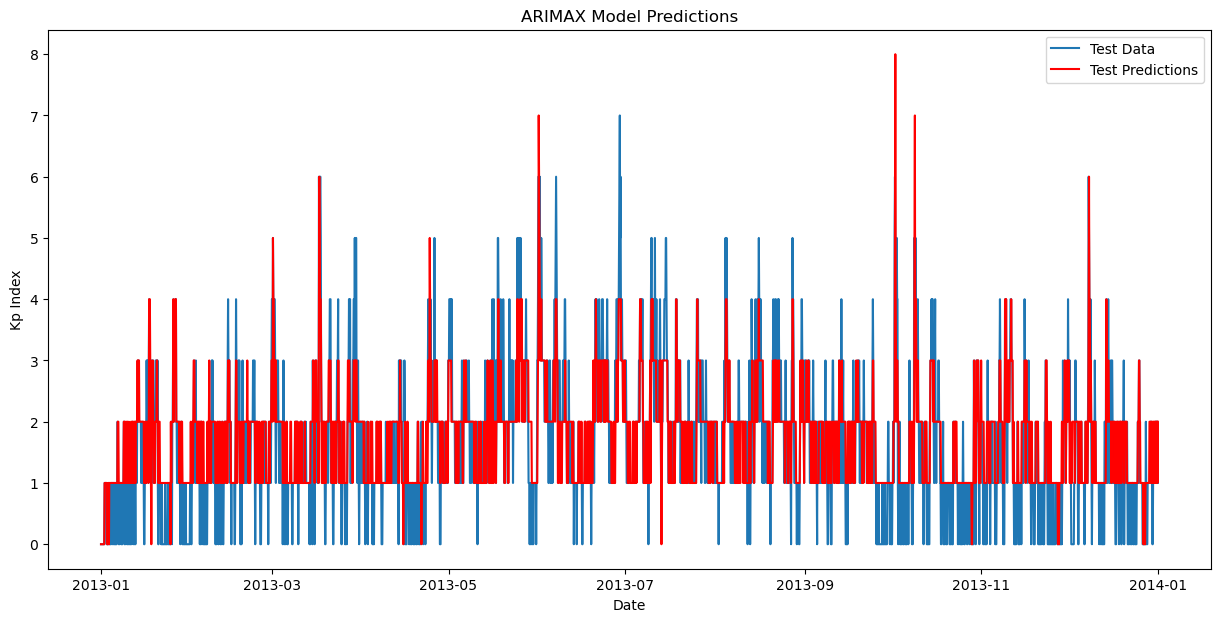

In [66]:
plt.figure(figsize=(15, 7))
plt.plot(test_Y_data, label='Test Data')
plt.plot(test_pred, label='Test Predictions', color='red')
plt.title('ARIMAX Model Predictions')
plt.xlabel('Date')
plt.ylabel('Kp Index')
plt.legend()
plt.show()